# import

In [115]:
from control import matlab
from matplotlib import pyplot as plt
import numpy as np
from scipy import linalg as LA

# class

In [116]:
class systemd:
    def __init__(self, A, B, E, C, Ts):
        br, bc = B.shape
        cr, cc = C.shape
        sys1 = matlab.ss(A, B, C, np.zeros((cr, bc)))
        sys1d = matlab.c2d(sys1, Ts)
        br, bc = E.shape
        cr, cc = C.shape
        sys2 = matlab.ss(A, E, C, np.zeros((cr, bc)))
        sys2d = matlab.c2d(sys2, Ts)
        self.A = sys1d.A
        self.B = sys1d.B
        self.E = sys2d.B
        self.C = sys1d.C
        
    def update(self, x1, u1, d1):
        x2 = self.A.dot(x1) + self.B.dot(u1) + self.E.dot(d1)
        y2 = self.C.dot(x1)
        return x2, y2
    
class mycontrol:
    """
    離散システム用
    y(k+1) = Ad*x(t) + Bd*u(k) + Ed*d(k) 想定
    """
            
    def ss(A, B, E, C, Ts):
        return systemd(A, B, E, C, Ts)
    
    def lqrd(A, B, Q, R):
        """
        離散系最適レギュレータ
        """
        P = LA.solve_discrete_are(A, B, Q, R)
        K = LA.inv(R+B.T.dot(P).dot(B)).dot(B.T).dot(P).dot(A)
        E = None
        
        return P, K, E
    
def rmse(en, gn, mes=None):
    if mes!=None:
        print(mes)
    for i in range(len(en)):
        e, g = en[i], gn[i]
        n = e.shape[0]
        print(g, np.sqrt(np.sum(e*e)/n))

# Param

In [117]:
# 入力値
m = 534 # 車体重量 kg
Is = 785 # 車体の慣性モーメント kg*m^2
kf = 13569 # 前輪支持ばね定数 N/m
kr = 17681 # 後輪支持ばね定数 N/m
cf = 1200 # 前輪支持減衰定数 Ns/m
cr = 1299 # 後輪支持減衰定数 Ns/m
a = 1.2 # 車体重心と前輪軸間距離 mb
b = 1.3 # 車体重心と後輪軸間距離 m

Ts = 0.001 # サンプリング周期 sec
hd = 0.08 # 外乱高さ m
ld = 0.5 # 外乱長さ m
dl = 5 # 外乱までの距離 m

h = np.array([1, 1])*10**-5 # 重み行列H用 1x2

Cp = np.array(
    [
        [1, 0, 0, 0],
        [0, 0, 1, 0]
    ]
)

# 計算値
l = a+b  # ホイールベース間距離 m
H = np.diag(h)  # 重み行列H 2x2

Ap = np.array(
    [
        [0, 1, 0, 0],
        np.array([-(kf+kr), -(cf+cr), kf*a-kr*b, cf*a-cr*b])/m,
        [0, 0, 0, 1],
        np.array([kf*a-kr*b, cf*a-cr*b, -(kf*a*a+kr*b*b), -(cf*a*a+cr*b*b)])/Is
    ]
)
Bp = np.array(
    [
        [0, 0],
        [1/m, 1/m],
        [0, 0],
        [-a/Is, b/Is]
    ]
)
Ep = np.array(
    [
        [0, 0, 0, 0],
        np.array([kf, cf, kr, cr])/m,
        [0, 0, 0, 0],
        np.array([-kf*a, -cf*a, kr*b, cr*b])/Is
    ]
)

# 外乱

In [118]:
def w_dist(x):
    if x<= l:
        return 0
    elif x<= l+ld:
        return hd*(1-np.cos(2*np.pi*(x-l)/ld))/2
    else:
        return 0
    
def w_distd(x):
    xd = x%(l+ld+5)
    if xd<= l:
        return 0
    elif xd<= l+ld:
        return hd*(1-np.cos(2*np.pi*(xd-l)/ld))/2
    else:
        return 0
    
def dist(x, l):
    return w_dist(x+l), w_dist(x)

# sim2 加速度一定

In [125]:
# run all sim2

In [120]:
sysd = mycontrol.ss(Ap, Bp, Ep, Cp, Ts)

start_time = 0
end_time = 1
t = np.arange(start_time, end_time, Ts)

# 0-100km/h : 12秒程度
# 最大の加速度=>加速度 : 8.5km/h程度
# 加速度 6km/h と仮定
start_v = 30
ac_v = 6
vs = start_v*1000/3600
ac = ac_v*1000/3600

q = np.array([1, 100, 1, 1, 1, 1])
Q = np.diag(q)

phi = np.vstack(
    [
        np.hstack([np.eye(2), -sysd.C.dot(sysd.A)]),
        np.hstack([np.zeros([4, 2]), sysd.A])
    ]
)
G = np.vstack(
    [
        -sysd.C.dot(sysd.B),
        sysd.B
    ]
)
Gd = np.vstack(
    [
        -sysd.C.dot(sysd.E),
        sysd.E
    ]
)
syser = mycontrol.ss(phi, G, Gd, np.eye(6), Ts)

P, K, E = mycontrol.lqrd(phi, G, Q, H)
K = -K
Fe, Fx = np.hsplit(K, [2])

step = 43 # 予見ステップ数
yoken = np.zeros((2, 4, 1))
Fd = np.zeros((step, 2, 4))
for i in range(step):
    Fd[i] = -LA.inv(H+G.T.dot(P).dot(G)).dot(G.T).dot(np.linalg.matrix_power((phi+G.dot(K)).T, i+1)).dot(P).dot(Gd)

## Non Preview

In [121]:
# エラーシステム
x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))

for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    u[i+1] = u[i] + du
    
    v += ac*Ts
    
x21, y21, u21, d21, dis21 = x, y, u, d, dis

print('v={0}'.format(v*3600/1000))

v=35.99400000000094


## Preview System (速度一定)

In [122]:
# 速度対応 予見システム
x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
s = int(l/(v*Ts)+0.5)


for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
#     # 予見情報
#     if i<t.size-Mmax-1:
#         yoken[i+1+Mmax][2] = d[i+1][0]
#         yoken[i+1+Mmax][3] = d[i+1][1]
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    Mmax = int(l/(v*Ts))
    for j in range(step):
        k = i+j-s
        if k>0 and k<t.size-1:
            yoken[1][2:] = d[k+1][:2]
            yoken[0][2:] = d[k][:2]
            dw = yoken[1]-yoken[0]
            du += Fd[j].dot(dw)
    
#     for j in range(step):
#         k = i + j+1
#         dw = yoken[k+1]-yoken[k]
#         du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du
    v += ac*Ts
#     Mmax = int(l/(v*Ts))
    
x22, y22, u22, d22, dis22 = x, y, u, d, dis

## Preview System (加速度一定)

In [123]:
# 加速対応 予見制御
x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))
s = int((-v+np.sqrt(v*v+2*ac*l))/(ac*Ts))


for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i+j-s
        if k>0 and k<t.size-1:
            yoken[1][2:] = d[k+1][:2]
            yoken[0][2:] = d[k][:2]
            dw = yoken[1]-yoken[0]
            du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du    
    v += ac*Ts

    
x23, y23, u23, d23, dis23 = x, y, u, d, dis

## Preview System (予見情報が正しい)

In [124]:
# 予見情報が正しい場合
x = np.zeros((t.size, 4, 1))
y = np.zeros((t.size, 2, 1))
u = np.zeros((t.size, 2, 1))
d = np.zeros((t.size, 4, 1))
dis = np.zeros((t.size))
v = vs
e = np.zeros((t.size, 2, 1))

for i in range(t.size-1):
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts
    
    v += ac*Ts
    
v = vs
for i in range(t.size-1):
    x[i+1], y[i+1] = sysd.update(x[i], u[i], d[i])
    dis[i+1] = dis[i] + v*Ts
    d[i+1][0], d[i+1][2] = dist(dis[i+1], l)
    d[i+1][1][0] = (d[i+1][0]-d[i][0])/Ts
    d[i+1][3][0] = (d[i+1][2]-d[i][2])/Ts  
    
    e[i+1] = -y[i+1]
    dx = x[i+1] - x[i]
    du = Fe.dot(e[i+1]) + Fx.dot(dx)
    
    for j in range(step):
        k = i+j
        if k>0 and k<t.size-1:
            yoken[1][2:] = d[k+1][2:]
            yoken[0][2:] = d[k][2:]
            dw = yoken[1]-yoken[0]
            du += Fd[j].dot(dw)
    
    u[i+1] = u[i] + du    
    v += ac*Ts

    
x24, y24, u24, d24, dis24 = x, y, u, d, dis

# plot

In [130]:
# run all plot

## 状態変数x

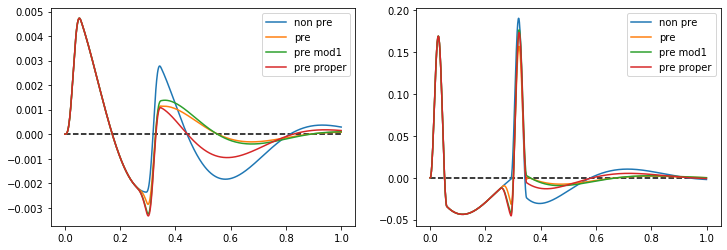

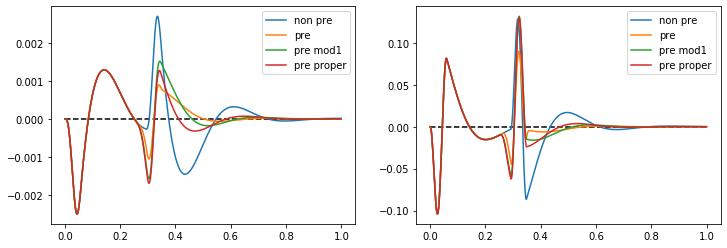

In [126]:
# 状態変数x
yn = (x21, x22, x23, x24)
gn = ('non pre', 'pre', 'pre mod1', 'pre proper')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

## 入力u

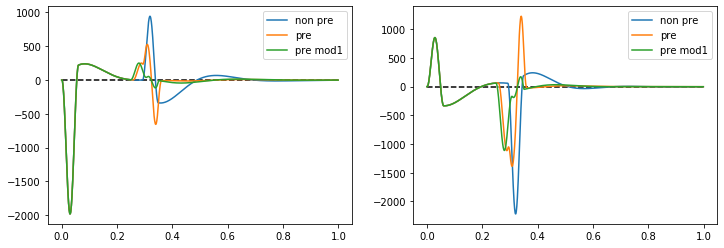

In [127]:
# 入力u
yn = (u21, u22, u23)
gn = ('non pre', 'pre', 'pre mod1', 'pre proper')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

## 外乱d

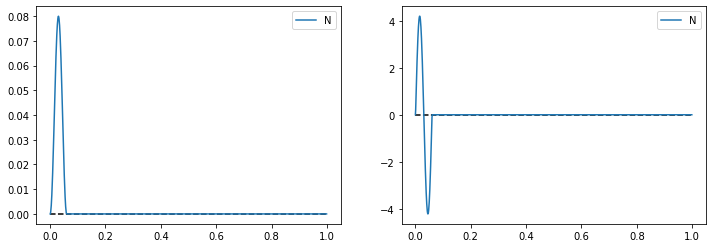

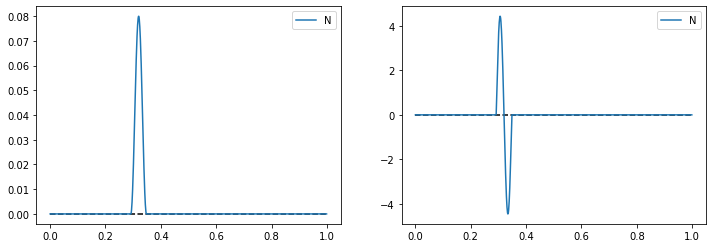

In [128]:
# 外乱d
yn = (d21,)
gn = ('None')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 0], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 1], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 2], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

plt.subplot(1, 2, 2)
for i in range(len(yn)):
    plt.plot(t, yn[i][:, 3], label=gn[i])
plt.legend()
plt.hlines([0], 0, end_time, linestyles='dashed')

## 距離dis

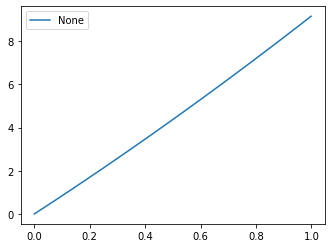

In [129]:
# 距離dis
yn = (dis21,)
gn = ('None',)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(len(yn)):
    plt.plot(t, yn[i], label=gn[i])
plt.legend()

# 平均誤差率

In [138]:
#run all rmse

In [132]:
mes = '入力-前輪 '
en = (u21[:, 0], u22[:, 0], u23[:, 0], u24[:, 0])
gn = ('Non Preview', 'Preview', 'Preview mod1', 'Preview proper')
rmse(en, gn, mes)

入力-前輪 
Non Preview 339.6305584233765
Preview 319.48026095589495
Preview mod1 302.73935787370743
Preview proper 303.3890750478707


In [133]:
mes = '入力-後輪'
en = (u21[:, 1], u22[:, 1], u23[:, 1], u24[:, 1])
gn = ('Non Preview', 'Preview', 'Preview mod1', 'Preview proper')
rmse(en, gn, mes)

入力-後輪
Non Preview 357.81713831221003
Preview 319.8178225544749
Preview mod1 225.0290401127464
Preview proper 232.9072648987095


In [134]:
mes = '車体上下変位'
en = (x21[:, 0]*100, x22[:, 0]*100, x23[:, 0]*100, x24[:, 0]*100)
gn = ('Non Preview', 'Preview', 'Preview mod1', 'Preview proper')
rmse(en, gn, mes)

車体上下変位
Non Preview 0.16620934544982446
Preview 0.14285103232701832
Preview mod1 0.14793422578578935
Preview proper 0.14843004583520653


In [135]:
mes = '車体上下速度'
en = (x21[:, 1]*100, x22[:, 1]*100, x23[:, 1]*100, x24[:, 1]*100)
gn = ('Non Preview', 'Preview', 'Preview mod1', 'Preview proper')
rmse(en, gn, mes)

車体上下速度
Non Preview 4.160779115000236
Preview 3.6860911524915965
Preview mod1 3.9021920881284364
Preview proper 3.880398385270923


In [136]:
mes = '角度変位'
en = (x21[:, 2]*100, x22[:, 2]*100, x23[:, 2]*100, x24[:, 2]*100)
gn = ('Non Preview', 'Preview', 'Preview mod1', 'Preview proper')
rmse(en, gn, mes)

角度変位
Non Preview 0.08324161787345882
Preview 0.0614662828529888
Preview mod1 0.06893422382436873
Preview proper 0.06606237586004092


In [137]:
mes = '角速度'
en = (x21[:, 3]*100, x22[:, 3]*100, x23[:, 3]*100, x24[:, 3]*100)
gn = ('Non Preview', 'Preview', 'Preview mod1', 'Preview proper')
rmse(en, gn, mes)

角速度
Non Preview 3.1425017037027088
Preview 2.4401033674676404
Preview mod1 2.8696996390786125
Preview proper 2.8717480399477067


# 実行コマンド

In [119]:
# run preparation

In [131]:
# run all sim2 plot2